In [10]:
#private cell
import openai
import os

REPLICATE_API_TOKEN = ""
os.environ["REPLICATE_API_TOKEN"] = REPLICATE_API_TOKEN


path = "/Source_Materials/"
openai.api_key = ""
anthropic_api_key = ""

print ("Done")

Done


In [12]:
import openai
from collections import Counter
import replicate
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
with open (f"{path}Trident_OCR.txt", 'r') as f: 
    text = f.read()


preamble = '''
You are roleplaying as a judge. The following case comes in front of you. The borrower seeks to prepay a loan they took. The promissory note states: '''


query = '''Based on this promissory note, the borrower contends it has a right to compel early prepayment before January 1996 by defaulting. The lender disputes this interpretation, arguing that prepayment is prohibited.
Rate the following proposition on a 1-100 scale, where 0 is wrong and 100 is correct. Use exact and specific probabilities with one decimal precision, not rounded numbers.
The language is REASONABLY susceptible to being read as providing the borrower the right to early prepayment

Start your answer in this format: "Rating = X/100. Explanation = "
'''
prompt = f'{preamble}   \n {text} \n {query}' 

prompt

'\nYou are roleplaying as a judge. The following case comes in front of you. The borrower seeks to prepay a loan they took. The promissory note states:    \n [The Promissory Note on Trident Center]\n388-030\n10/22/83\nPROMISSORY NOTE\n$56,500,000\nLos Angeles, California\nNovember 30, 1983\n\nFOR VALUE RECEIVED, and at the times and in the manner hereinafter stated, the undersigned, TRIDENT CENTER, a California limited partnership ("Maker"), promises to pay to the order of CONNECTICUT GENERAL LIFE INSURANCE COMPANY, a Connecticut corporation ("Holder"), at its office at Hartford, Connecticut 06152, or at such other place, either within or without the State of California as the holder hereof may from time to time designate in writing, in legal tender of the United States of America, the principal sum of FIFTY-SIX MILLION FIVE HUNDRED THOUSAND DOLLARS ($56,500,000) or so much as may be disbursed with interest from the date of disbursement on the unpaid principal balance and any other adv

In [24]:
# Define function to get the output with "/100" break logic
def get_output_with_break(prompt):
    output = replicate.run(
        "andreasjansson/sheep-duck-llama-2-70b-v1-1-gguf:a8d46304cdc3e0b4f18773b2863a0bf24a1daa7fd43e9e94f6d7f197a759152b",
        input={"prompt": f"{prompt}",  "max_tokens": 150, "temperature": 1, "top_p": 1}
    )

    break_string = "/100"
    buffer = ""
    for item in output:
        buffer += item
        if break_string in buffer:
            buffer = buffer.split(break_string)[0] + break_string  # truncate after the detected string
            break
    return buffer

# Accumulate results
results = []
for _ in range(100):
    result = get_output_with_break(prompt)
    results.append(result)

# Save to Excel
df = pd.DataFrame(results, columns=['Response'])
df.to_excel('d:/outputs/Trident_sheep-duck-llama-2-70b.xlsx', index=False)


In [40]:
import time

def save_to_excel(model_name, question_list, response_list):
    directory = 'd:/outputs'
    if not os.path.exists(directory):
        os.makedirs(directory)
    df = pd.DataFrame({'Question': question_list, 'Response': response_list})
    filename = f"Ellington_{model_name}.xlsx"
    df.to_excel(os.path.join(directory, filename), index=False)

def query_openai_model(model_name, text):
    completions = []
    while True:
        try:
            time.sleep(5)  # 5-second wait between queries
            response = openai.ChatCompletion.create(
                model=model_name,
                temperature=1,
                top_p=1,
                n=10,  # Requesting 10 completions
                messages=[
                    {"role": "system", "content": "You are a helpful assistant."},
                    {"role": "user", "content": f"{text}"}
                ]
            )
            completions.extend([choice['message']['content'] for choice in response['choices']])
            for completion in completions:
                print(completion)  # Print the response
            return completions
        except openai.error.RateLimitError as e:
            error_message = e.args[0] if e.args else str(e)
            wait_time = int(error_message.split("Please try again in ")[1].split("ms")[0]) / 1000
            print(f"Rate limit reached. Waiting for {wait_time} seconds...")
            time.sleep(wait_time)

def query_anthropic_model(model_name, text):
    anthropic = Anthropic(api_key=anthropic_api_key)
    responses = []
    for _ in range(10):  # Requesting 10 completions through iteration
        completion = anthropic.create(
            model=model_name,
            max_tokens_to_sample=250,
            temperature=1,
            top_p=1,
            prompt=f"{HUMAN_PROMPT} {text}.{AI_PROMPT}"
        )
        responses.append(completion.completion)
    return responses

models = ['gpt-4', 'claude-2']

for model in models:
    all_questions = []
    all_responses = []
    
    # Process each question
    for question in questions:
        prompt = f"{preamble} {contract} {question}"
        
        if model == 'gpt-4':
            responses = query_openai_model(model, prompt)
            # Immediately save GPT-4 responses after querying
            all_questions.extend([question] * 10)
            all_responses.extend(responses)
            save_to_excel(model, all_questions, all_responses)
        elif model == 'claude-2':
            responses = query_anthropic_model(model, prompt)
            all_questions.extend([question] * 10)
            all_responses.extend(responses)
    
    if model == 'claude-2':  # Save Claude-2 responses after all queries are done
        save_to_excel(model, all_questions, all_responses)


NameError: name 'questions' is not defined

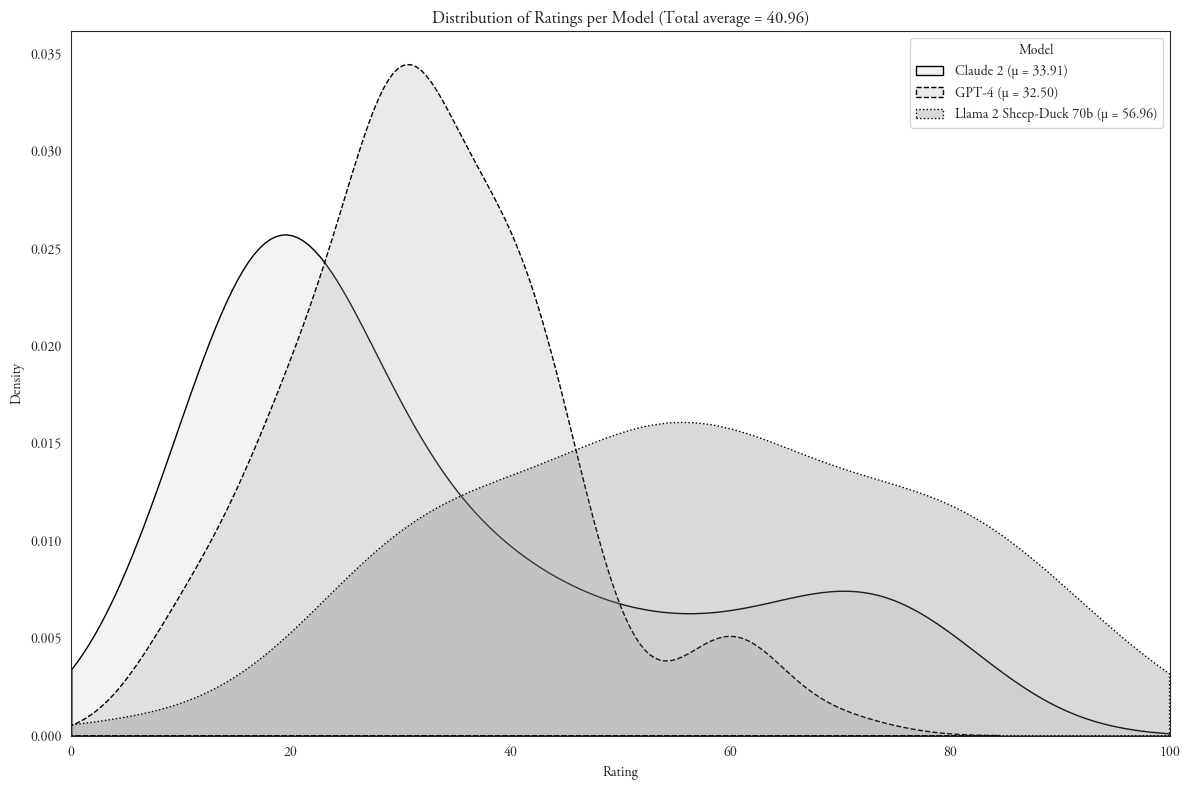

In [39]:
def extract_ratings(response_column):
    """Extract ratings from the response column."""
    ratings = []
    for response in response_column:
        # Extract rating using regex
        match = re.search(r'(\d+(\.\d+)?)/100', response)
        if match:
            ratings.append(float(match.group(1)))
    return ratings

# File paths for the Excel files on your local machine
file_paths = {
    "Claude 2": r"c:\Users\yonat\Box\Sync\Work\Papers\Drafting Ks\New_Scripts\Outputs\Trident_claude-2_Responses.xlsx",
    "GPT-4": r"c:\Users\yonat\Box\Sync\Work\Papers\Drafting Ks\New_Scripts\Outputs\Trident_gpt-4_Responses.xlsx",
    "Llama 2 Sheep-Duck 70b": r"c:\Users\yonat\Box\Sync\Work\Papers\Drafting Ks\New_Scripts\Outputs\Trident_sheep-duck-llama-2-70b.xlsx"
}

# Extract ratings for each model and compute model's average rating
ratings_per_model = {}
model_avg_ratings = {}
all_ratings = []
for model, file_path in file_paths.items():
    data = pd.read_excel(file_path)
    model_ratings = extract_ratings(data['Responses'])
    ratings_per_model[model] = model_ratings
    model_avg_ratings[model] = sum(model_ratings) / len(model_ratings)
    all_ratings.extend(model_ratings)

# Compute the average of all ratings
avg_rating = sum(all_ratings) / len(all_ratings)

# Set style and font
sns.set_style("white")
plt.rcParams['font.family'] = 'Adobe Garamond Pro'

# Initialize the figure
plt.figure(figsize=(12, 8))

# Distinct shades of gray for filling
colors = ["#D3D3D3", "#A9A9A9", "#696969"]

# Linestyles for distinction
linestyles = ['-', '--', ':']

# Plot KDE for each model with distinct linestyles for outlines
labels = [f"{model} (μ = {model_avg_ratings[model]:.2f})" for model in ratings_per_model.keys()]
for model, ratings, color, label, linestyle in zip(ratings_per_model.keys(), ratings_per_model.values(), colors, labels, linestyles):
    sns.kdeplot(ratings, fill=True, color=color, linewidth=1, edgecolor='black', clip=(0, 100), linestyle=linestyle, label=label)

# Set plot title with average rating, labels, and axis limits
plt.title(f"Distribution of Ratings per Model (Total average = {avg_rating:.2f})")
plt.xlabel("Rating")
plt.ylabel("Density")
plt.xlim(0, 100)
plt.legend(title="Model")
plt.tight_layout()
plt.show()
